In [1]:
!pip uninstall -y gym
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 2.8 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gymnasium]


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym # Changed from 'import gym'
from collections import deque
import matplotlib.pyplot as plt

In [4]:
class PolicyNetwork(nn.Module):
    """Neural network for policy approximation"""
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

In [6]:
class ValueNetwork(nn.Module):
    """Neural network for value function approximation"""
    def __init__(self, state_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        # Storage for episode
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        """Select action according to policy"""
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_probs.append(dist.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        """Store reward for current step"""
        self.rewards.append(reward)

    def update(self):
        """Update policy using REINFORCE algorithm"""
        # Calculate discounted returns
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        # Normalize returns (optional but helps with stability)
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Calculate policy loss
        policy_loss = []
        for log_prob, G in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * G)

        # Perform backprop
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        # Clear episode storage
        self.log_probs = []
        self.rewards = []

        return policy_loss.item()

In [8]:
class ActorCritic:

    def __init__(self, state_dim, action_dim, lr_actor=0.001, lr_critic=0.001, gamma=0.99):
        self.gamma = gamma

        # Actor (policy) and Critic (value function)
        self.actor = PolicyNetwork(state_dim, action_dim)
        self.critic = ValueNetwork(state_dim)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Storage for episode
        self.log_probs = []
        self.values = []
        self.rewards = []

    def select_action(self, state):
        """Select action and compute value estimate"""
        state = torch.FloatTensor(state).unsqueeze(0)

        # Get action probabilities from actor
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()

        # Get value estimate from critic
        value = self.critic(state)

        self.log_probs.append(dist.log_prob(action))
        self.values.append(value)

        return action.item()

    def store_reward(self, reward):
        """Store reward for current step"""
        self.rewards.append(reward)

    def update(self):
        """Update actor and critic using advantage"""
        # Calculate returns and advantages
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.FloatTensor(returns)
        values = torch.cat(self.values)

        # Calculate advantages (TD error)
        advantages = returns - values.squeeze().detach()

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Actor loss (policy gradient with advantage)
        actor_loss = []
        for log_prob, advantage in zip(self.log_probs, advantages):
            actor_loss.append(-log_prob * advantage)
        actor_loss = torch.stack(actor_loss).sum()

        # Critic loss (MSE between predicted value and actual return)
        critic_loss = F.mse_loss(values.squeeze(), returns)

        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Clear episode storage
        self.log_probs = []
        self.values = []
        self.rewards = []

        return actor_loss.item(), critic_loss.item()


In [9]:
class A2C:
    
    def __init__(self, state_dim, action_dim, lr_actor=0.001, lr_critic=0.001, gamma=0.99):
        self.gamma = gamma

        self.actor = PolicyNetwork(state_dim, action_dim)
        self.critic = ValueNetwork(state_dim)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

    def select_action(self, state):
        """Select action from policy"""
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update(self, state, action_log_prob, reward, next_state, done):
        """Update after each step"""
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Get value estimates
        value = self.critic(state)
        next_value = self.critic(next_state)

        # Calculate TD error (advantage)
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * next_value.item()

        advantage = td_target - value.item()

        # Actor loss
        actor_loss = -action_log_prob * advantage

        # Critic loss
        critic_loss = F.mse_loss(value, torch.FloatTensor([[td_target]]))

        # Update networks
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

In [10]:
def train_reinforce(env_name='CartPole-v1', episodes=1000, render=False):
    """Train using REINFORCE algorithm"""
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = REINFORCE(state_dim, action_dim)

    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    print(f"Training REINFORCE on {env_name}...")

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_reward = 0
        done = False

        while not done:
            if render and episode % 100 == 0:
                env.render()

            action = agent.select_action(state)
            result = env.step(action)

            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

        # Update policy after episode
        loss = agent.update()

        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(recent_rewards)
            print(f"Episode {episode+1}, Avg Reward: {avg_reward:.2f}, Loss: {loss:.4f}")

    env.close()
    return episode_rewards

In [11]:
def train_actor_critic(env_name='CartPole-v1', episodes=1000, render=False):
    """Train using Actor-Critic algorithm"""
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ActorCritic(state_dim, action_dim)

    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    print(f"\nTraining Actor-Critic on {env_name}...")

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_reward = 0
        done = False

        while not done:
            if render and episode % 100 == 0:
                env.render()

            action = agent.select_action(state)
            result = env.step(action)

            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

        # Update policy and value function after episode
        actor_loss, critic_loss = agent.update()

        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(recent_rewards)
            print(f"Episode {episode+1}, Avg Reward: {avg_reward:.2f}, "
                  f"Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}")

    env.close()
    return episode_rewards

In [12]:
def train_a2c(env_name='CartPole-v1', episodes=1000, render=False):
    """Train using A2C (online) algorithm"""
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = A2C(state_dim, action_dim)

    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    print(f"\nTraining A2C on {env_name}...")

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_reward = 0
        done = False

        while not done:
            if render and episode % 100 == 0:
                env.render()

            action, log_prob = agent.select_action(state)
            result = env.step(action)

            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            # Update after each step
            actor_loss, critic_loss = agent.update(state, log_prob, reward, next_state, done)

            episode_reward += reward
            state = next_state

        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(recent_rewards)
            print(f"Episode {episode+1}, Avg Reward: {avg_reward:.2f}")

    env.close()
    return episode_rewards

In [13]:
def plot_results(reinforce_rewards, ac_rewards, a2c_rewards):
    """Plot training results for comparison"""
    plt.figure(figsize=(12, 5))

    # Smooth rewards for better visualization
    def smooth(data, weight=0.9):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    plt.subplot(1, 2, 1)
    plt.plot(reinforce_rewards, alpha=0.3, label='REINFORCE (raw)')
    plt.plot(smooth(reinforce_rewards), label='REINFORCE (smoothed)')
    plt.plot(ac_rewards, alpha=0.3, label='Actor-Critic (raw)')
    plt.plot(smooth(ac_rewards), label='Actor-Critic (smoothed)')
    plt.plot(a2c_rewards, alpha=0.3, label='A2C (raw)')
    plt.plot(smooth(a2c_rewards), label='A2C (smoothed)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress: All Algorithms')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    window = 100
    reinforce_avg = [np.mean(reinforce_rewards[max(0, i-window):i+1])
                     for i in range(len(reinforce_rewards))]
    ac_avg = [np.mean(ac_rewards[max(0, i-window):i+1])
              for i in range(len(ac_rewards))]
    a2c_avg = [np.mean(a2c_rewards[max(0, i-window):i+1])
               for i in range(len(a2c_rewards))]

    plt.plot(reinforce_avg, label='REINFORCE')
    plt.plot(ac_avg, label='Actor-Critic')
    plt.plot(a2c_avg, label='A2C')
    plt.xlabel('Episode')
    plt.ylabel(f'Average Reward (last {window} episodes)')
    plt.title('Moving Average Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('policy_gradient_comparison.png', dpi=150)
    print("\nPlot saved as 'policy_gradient_comparison.png'")
    plt.show()

Training REINFORCE on CartPole-v1...
Episode 50, Avg Reward: 32.42, Loss: -0.2182
Episode 100, Avg Reward: 40.72, Loss: 0.4235
Episode 150, Avg Reward: 61.72, Loss: -0.6637
Episode 200, Avg Reward: 66.69, Loss: 0.8639
Episode 250, Avg Reward: 71.45, Loss: 0.5748
Episode 300, Avg Reward: 103.18, Loss: -1.3477
Episode 350, Avg Reward: 116.05, Loss: -2.5142
Episode 400, Avg Reward: 112.78, Loss: -5.6725
Episode 450, Avg Reward: 243.18, Loss: -0.6911
Episode 500, Avg Reward: 390.19, Loss: 5.9645

Training Actor-Critic on CartPole-v1...
Episode 50, Avg Reward: 38.40, Actor Loss: 0.0519, Critic Loss: 724.9679
Episode 100, Avg Reward: 59.21, Actor Loss: -0.8065, Critic Loss: 1019.1043
Episode 150, Avg Reward: 109.07, Actor Loss: 1.2438, Critic Loss: 857.3236
Episode 200, Avg Reward: 160.31, Actor Loss: -0.5616, Critic Loss: 2058.7805
Episode 250, Avg Reward: 167.08, Actor Loss: 3.8215, Critic Loss: 44.6936
Episode 300, Avg Reward: 133.66, Actor Loss: 3.8463, Critic Loss: 153.8674
Episode 350,

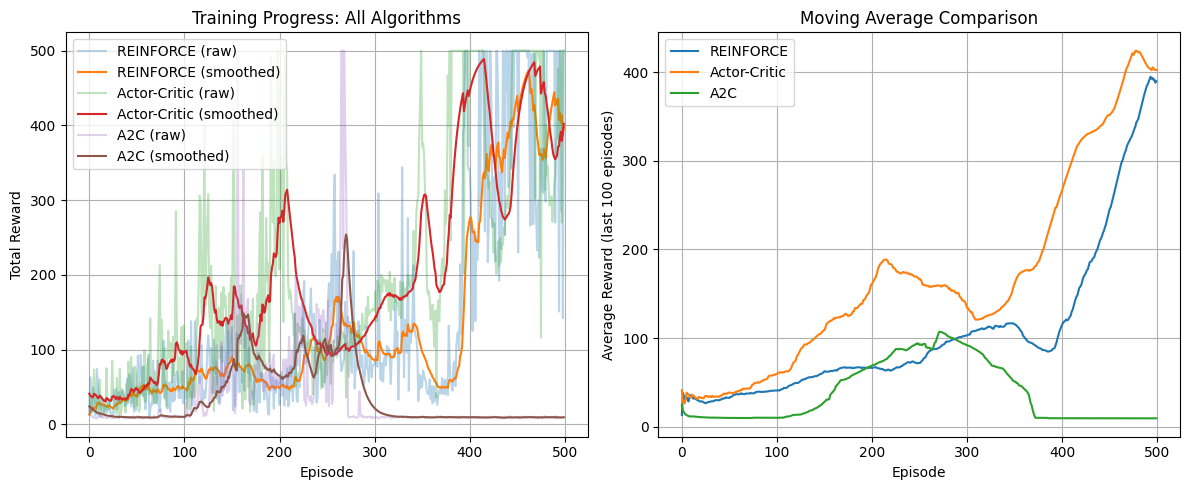

In [14]:
# Train all three algorithms
episodes = 500

reinforce_rewards = train_reinforce(episodes=episodes)
ac_rewards = train_actor_critic(episodes=episodes)
a2c_rewards = train_a2c(episodes=episodes)

# Plot comparison
plot_results(reinforce_rewards, ac_rewards, a2c_rewards)